In [1]:
from __future__ import print_function
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
""" Read Data """
train_variant = pd.read_csv("C:/Users/Aoos/Documents/Kaggle/Personalized Medicine/Data/training_variants/training_variants")
test_variant = pd.read_csv("C:/Users/Aoos/Documents/Kaggle/Personalized Medicine/Data/test_variants/test_variants")

In [3]:
len(train_variant['Class'].unique()) # 264 unique genes

9

In [4]:
train_variant.info() # 3321 len

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
test_variant.info() #5668 len

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 3 columns):
ID           5668 non-null int64
Gene         5668 non-null object
Variation    5668 non-null object
dtypes: int64(1), object(2)
memory usage: 132.9+ KB


In [6]:
len(test_variant['Gene'].unique()) #5668  unique genes

1397

In [7]:
train_text = pd.read_csv("C:/Users/Aoos/Documents/Kaggle/Personalized Medicine/Data/training_text/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("C:/Users/Aoos/Documents/Kaggle/Personalized Medicine/Data/test_text/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
train = pd.merge(train_variant, train_text, how='left', on='ID')
train_y = train['Class'].values
train_x = train.drop('Class', axis=1)
train_size=len(train_x)
print('Number of training variants: %d' % (train_size))

Number of training variants: 3321


In [8]:
train_x['Text'][:2]

0    Cyclin-dependent kinases (CDKs) regulate a var...
1     Abstract Background  Non-small cell lung canc...
Name: Text, dtype: object

In [9]:
test_x = pd.merge(test_variant, test_text, how='left', on='ID')
test_size=len(test_x)
print('Number of test variants: %d' % (test_size))

Number of test variants: 5668


In [10]:
test_index = test_x['ID'].values  
all_data = np.concatenate((train_x, test_x), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]

In [11]:
all_data.shape

(8989, 4)

In [12]:
import nltk
nltk.download("stopwords")
#abc=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aoos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

allText = all_data['Text'].apply(cleanup)
sentences = constructLabeledSentences(allText)
allText.head()

C:\Users\Aoos\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [14]:
# Modeling with Doc2Vec 

In [55]:
from gensim.models import Doc2Vec

Text_INPUT_DIM=400 # original 300


text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

In [56]:
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1
    
print(text_train_arrays[0][:50])

[-0.36334577  0.44653088  0.07787539 -0.13801119  0.08747821 -0.49483141
  0.5273661  -0.21344998 -0.16277395 -0.67110372  0.13769472 -0.35388631
 -0.09701432  0.06223047  0.01944162  0.37927297  0.03191559 -0.13455208
 -0.19167037  0.00311912  0.3329758  -0.51056927 -0.6344716   0.50305861
 -0.74639446 -0.32281986 -0.16520782  0.28132161 -0.7194224  -0.34481964
  0.74820799  0.66671348 -0.03372002 -0.61717135  0.82775635 -0.7193507
 -0.25253758 -0.60318214  0.0867671   0.53080577 -1.29245484 -0.49746683
 -0.67322719  0.30732793 -0.13690935  0.24046232 -0.07101041  0.36274478
 -0.55954325 -0.90608853]


In [57]:
from sklearn.decomposition import TruncatedSVD
Gene_INPUT_DIM=25 # changed from 25

svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

In [58]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
print(encoded_y[0])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [59]:
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))
print(train_set[0][:50])

[ -3.79802063e-25   6.18850141e-20   1.47527860e-22  -1.81430965e-22
  -1.67264168e-22   2.14663631e-23  -1.09403838e-25   1.89084305e-26
   8.63889669e-30  -3.37032391e-30  -5.15328857e-30   9.15919499e-29
   1.82046948e-28  -2.14449620e-28  -9.76804032e-29   1.31239389e-28
   2.33662401e-28   1.00722539e-27   3.78337896e-27   1.94103011e-27
  -4.79243594e-27   6.79846782e-27  -8.84929130e-27  -6.08941943e-26
   5.19953214e-26   1.00000000e+00  -1.72268088e-18   5.62379013e-19
  -2.53358358e-27   7.50133446e-27   4.91016951e-22   4.63871875e-24
  -7.26820962e-21  -3.61572682e-20   1.21572281e-20   1.95980134e-21
   8.83699919e-21  -3.25680576e-21   4.07134281e-20  -9.88552858e-17
   1.32595208e-16   2.38071446e-17   2.31000920e-17  -7.76276818e-17
   1.43312214e-16   3.76494646e-17  -2.20122715e-17   1.28149336e-16
  -1.09658371e-17   4.27144675e-17]


In [60]:
# Keras model

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD

def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [62]:
model = baseline_model()
model.summary()

C:\Users\Aoos\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=450, activation="relu", kernel_initializer="normal")`
C:\Users\Aoos\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
C:\Users\Aoos\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
C:\Users\Aoos\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               115456    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 80)                20560     
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 729       
Total params: 202,537
Trainable params: 202,537
Non-trainable params: 0
_________________________________________________________________


In [63]:
estimator=model.fit(train_set, encoded_y, validation_split=0.2, epochs=10, batch_size=64) # changed from 10

Train on 2656 samples, validate on 665 samples
Epoch 1/10
2656/2656 [==============================] - ETA: 19s - loss: 2.2034 - acc: 0.0938 - ETA: 3s - loss: 2.1810 - acc: 0.1068  - ETA: 1s - loss: 2.1525 - acc: 0.1354 - ETA: 0s - loss: 2.1026 - acc: 0.1745 - ETA: 0s - loss: 2.0440 - acc: 0.2085 - ETA: 0s - loss: 1.9982 - acc: 0.2344 - ETA: 0s - loss: 1.9564 - acc: 0.2515 - 0s - loss: 1.9530 - acc: 0.2534 - val_loss: 1.9472 - v

In [64]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 56.63% / Validation accuracy: 35.94%


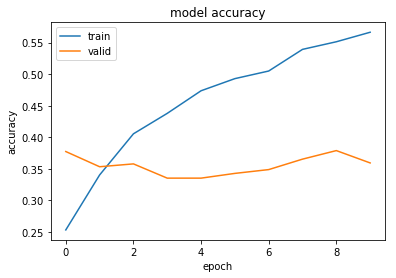

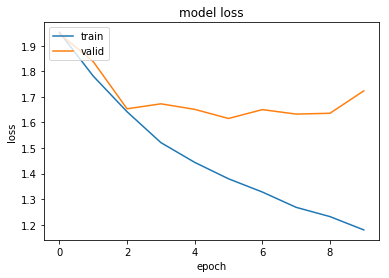

In [65]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [66]:
y_pred = model.predict_proba(test_set)

5088/5668 [=========================>....] - ETA: 8s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s

In [67]:
submission = pd.DataFrame(y_pred)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("submission_all.csv",index=False)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.000673,0.217531,0.005188,0.001347,0.009164,0.013600,0.751580,0.000402,0.000516,0
1,0.152170,0.007267,0.026614,0.700460,0.064761,0.030472,0.010042,0.003119,0.005095,1
2,0.245690,0.114035,0.047807,0.157942,0.099710,0.052142,0.256125,0.009922,0.016627,2
3,0.001138,0.171844,0.001911,0.001926,0.002818,0.001993,0.817948,0.000172,0.000250,3
4,0.148656,0.000857,0.006074,0.812849,0.023204,0.006372,0.001143,0.000285,0.000561,4
